In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,11/1/2019 0:00,1,15,20191101001
1,11/1/2019 1:00,1,13,20191101011
2,11/1/2019 2:00,1,10,20191101021
3,11/1/2019 3:00,1,7,20191101031
4,11/1/2019 4:00,1,9,20191101041


In [3]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

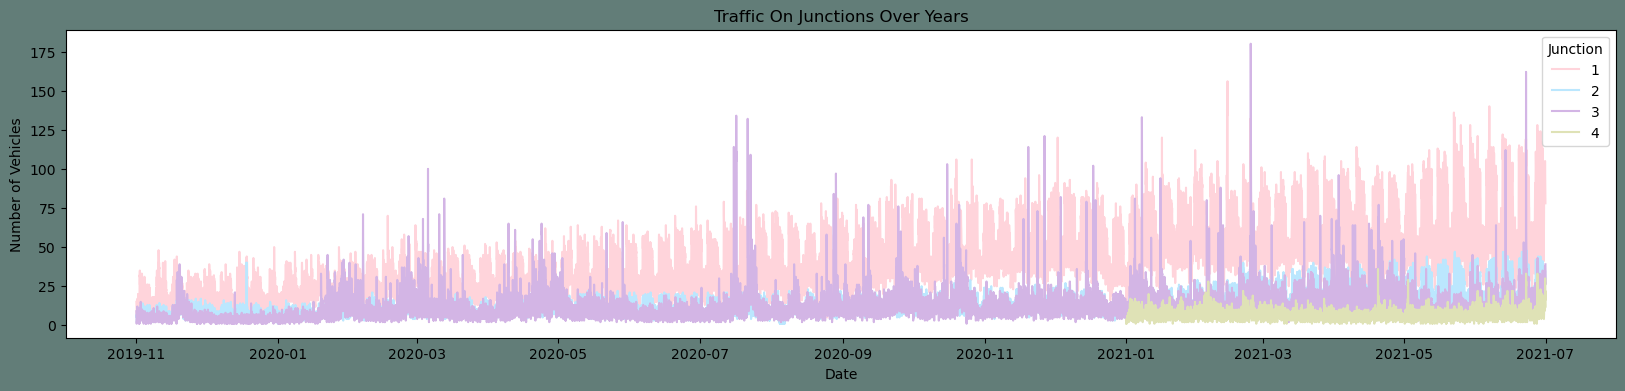

In [4]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [5]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2019-11-01 00:00:00,1,15,2019,11,1,0,Friday
1,2019-11-01 01:00:00,1,13,2019,11,1,1,Friday
2,2019-11-01 02:00:00,1,10,2019,11,1,2,Friday
3,2019-11-01 03:00:00,1,7,2019,11,1,3,Friday
4,2019-11-01 04:00:00,1,9,2019,11,1,4,Friday


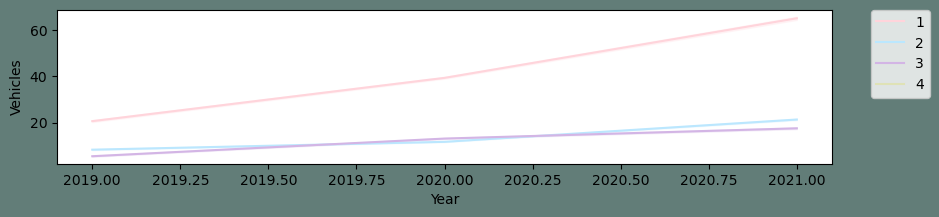

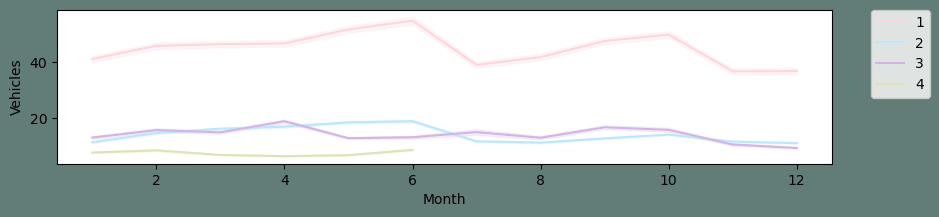

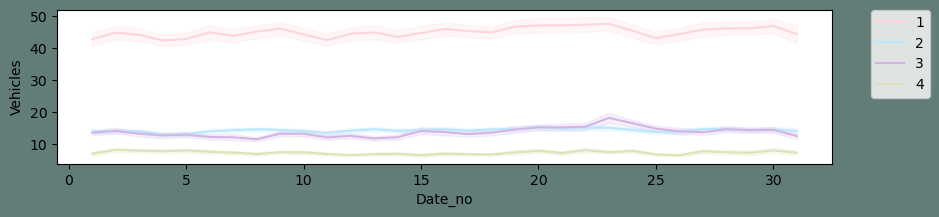

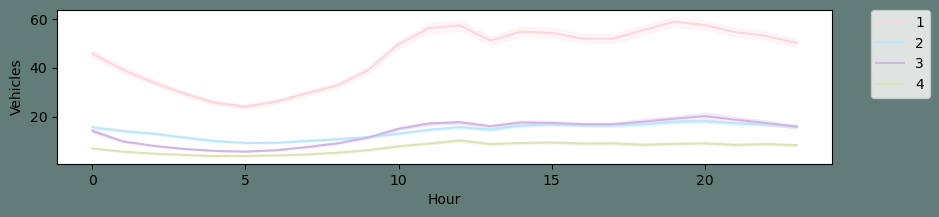

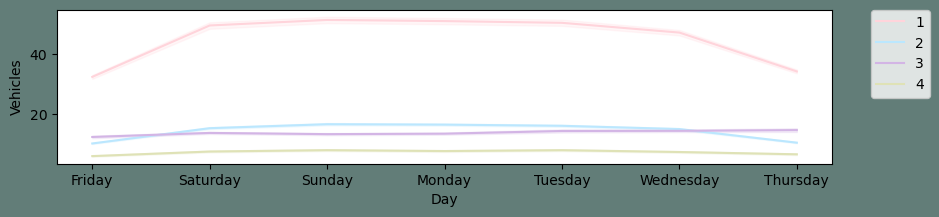

In [6]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

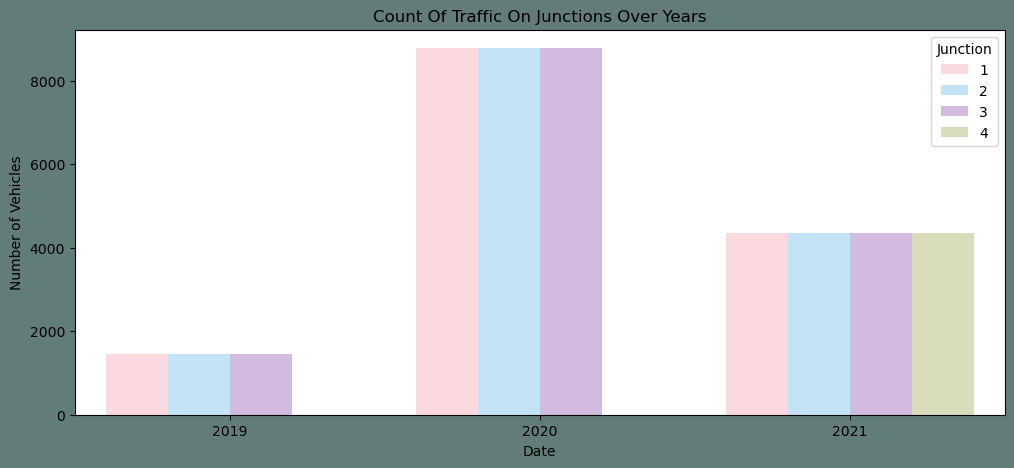

In [7]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<AxesSubplot:>

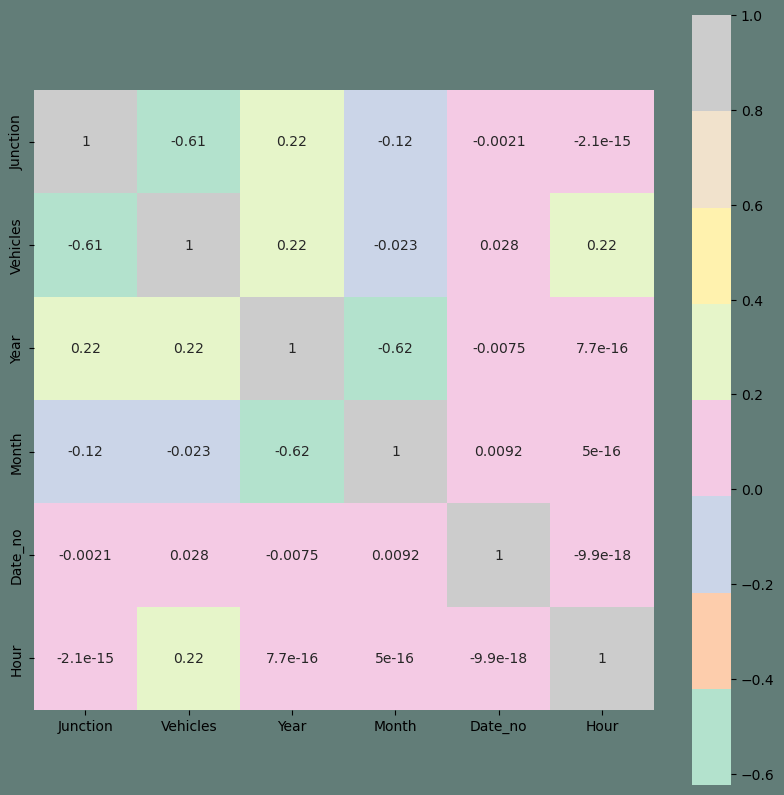

In [8]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

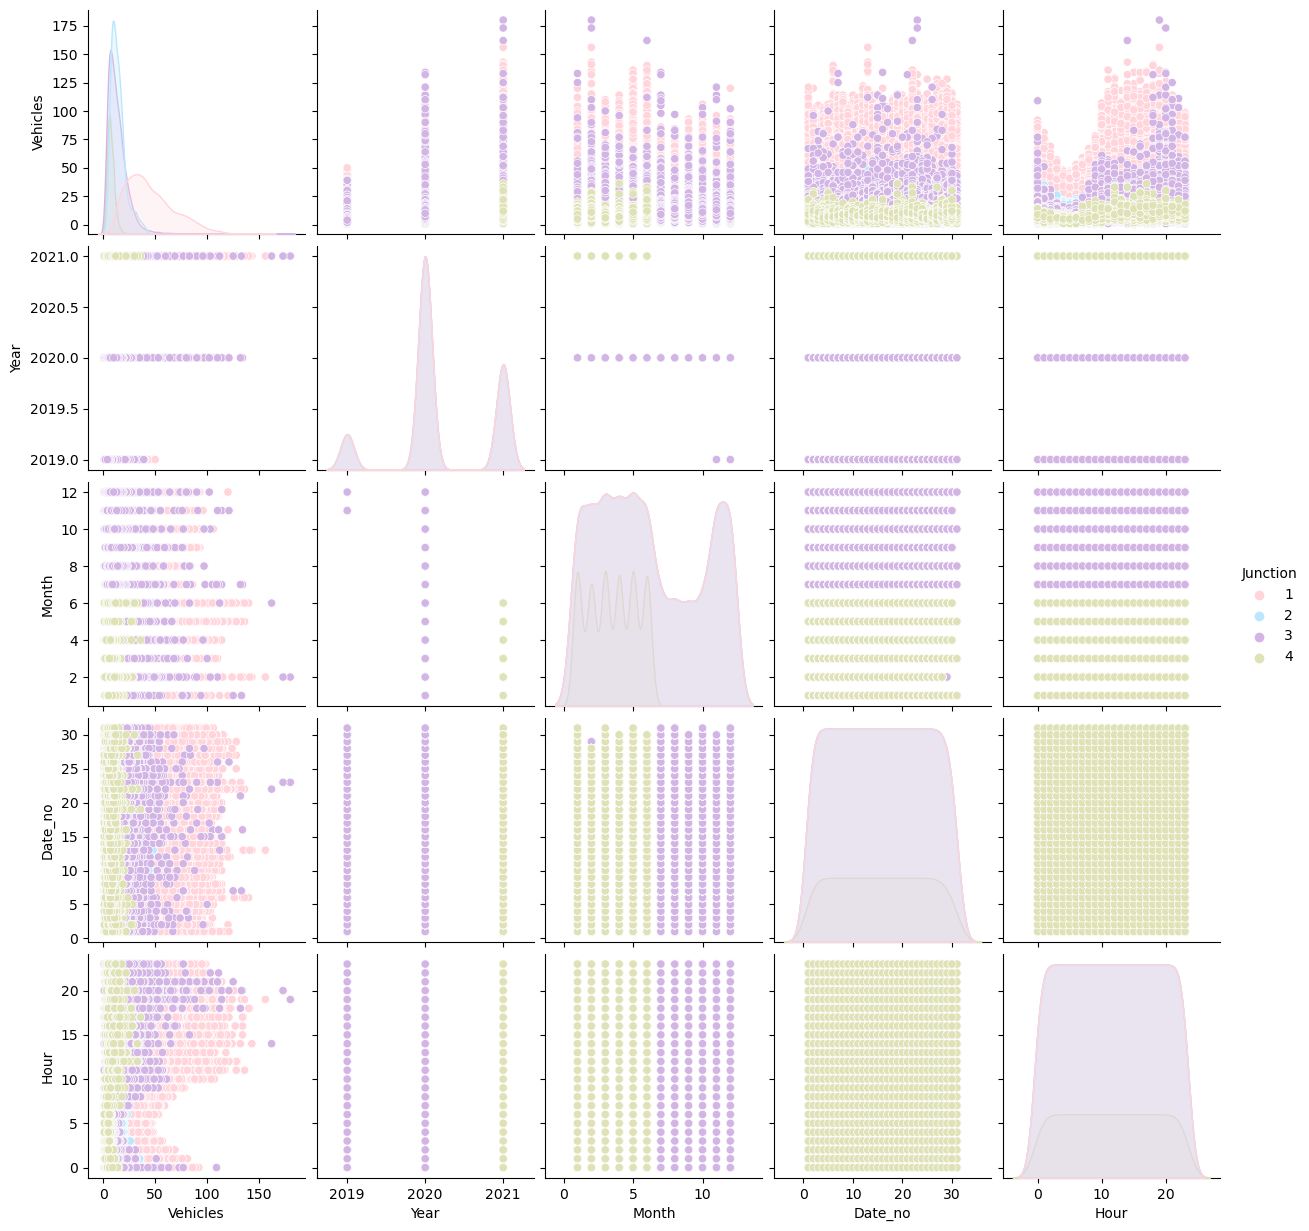

In [9]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [10]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

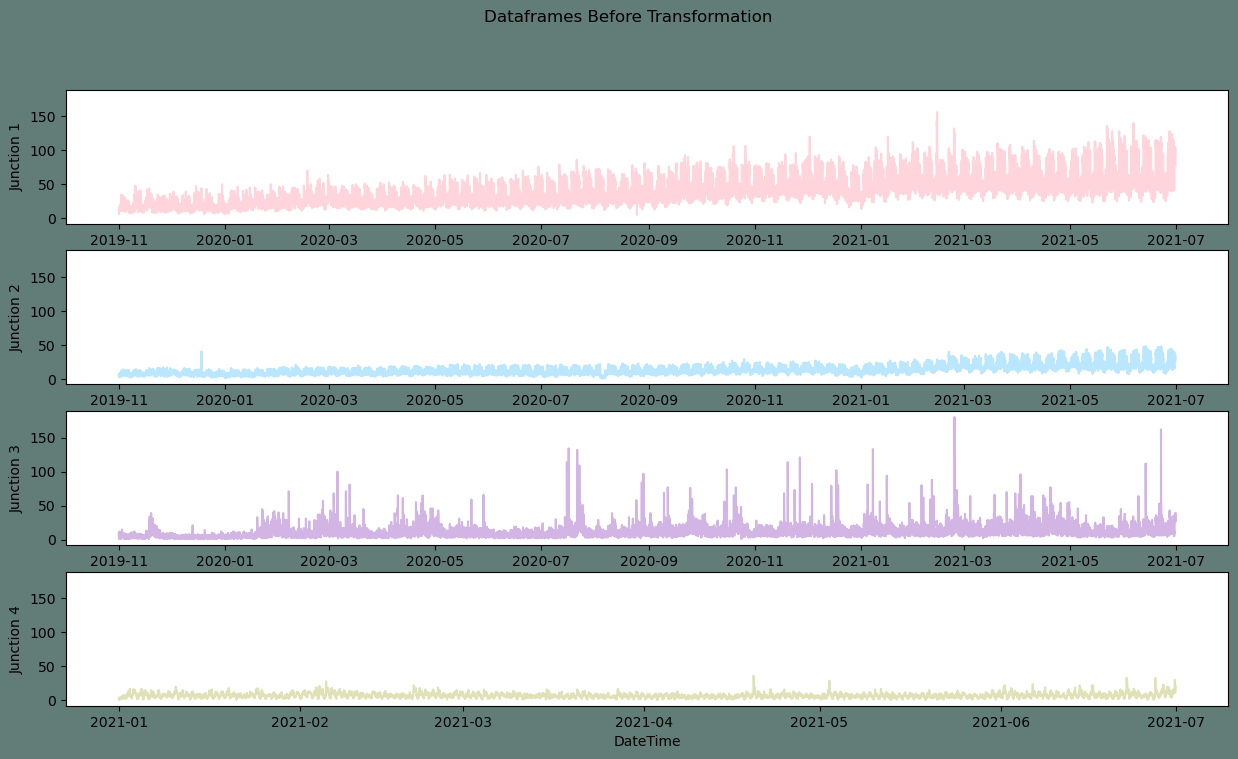

In [11]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [14]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [15]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

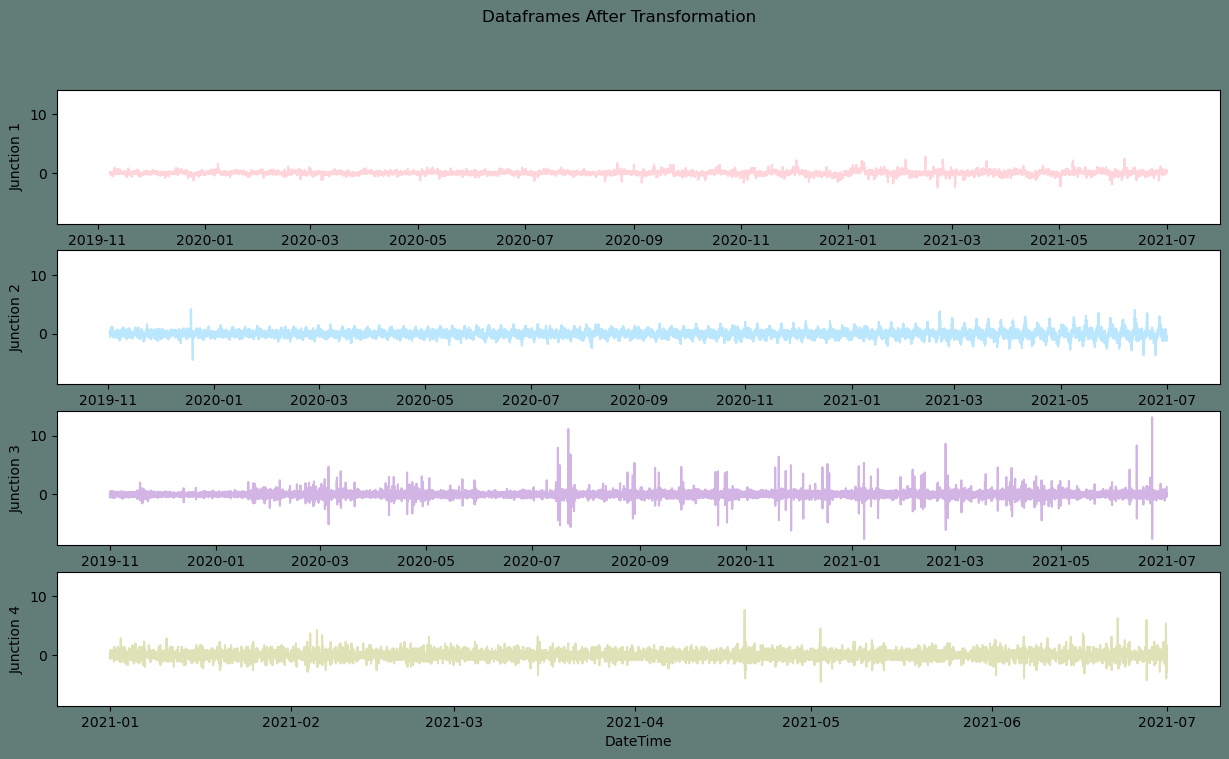

In [16]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [17]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415426
p-value: 4.7985398763968885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940296
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832412
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305261
p-value: 2.778787532594783e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [18]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [19]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [20]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - 127s 872ms/step - loss: 0.0755
Epoch 2/50
87/87 [==============================] - 83s 961ms/step - loss: 0.0658
Epoch 3/50
87/87 [==============================] - 86s 993ms/step - loss: 0.0644
Epoch 4/50
87/87 [==============================] - 83s 961ms/step - loss: 0.0626
Epoch 5/50
87/87 [==============================] - 82s 940ms/step - loss: 0.0611
Epoch 6/50
87/87 [==============================] - 96s 1s/step - loss: 0.0595
Epoch 7/50
87/87 [==============================] - 81s 929ms/step - loss: 0.0583
Epoch 8/50
87/87 [==============================] - 79s 910ms/step - loss: 0.0580
Epoch 9/50
87/87 [==============================] - 73s 838ms/step - loss: 0.0572
Epoch 10/50
87/87 [==============================] - 72s 828ms/step - loss: 0.0564
Epoch 11/50
87/87 [==============================] - 73s 838ms/step - loss: 0.0560
Epoch 12/50
87/87 [==============================] - 73s 845ms/step - loss: 0.0555
Epoch 13/50
87/

Epoch 32/50
87/87 [==============================] - 69s 788ms/step - loss: 0.0499
Epoch 33/50
87/87 [==============================] - 128s 1s/step - loss: 0.0499
Epoch 34/50
87/87 [==============================] - 93s 1s/step - loss: 0.0492
Epoch 35/50
87/87 [==============================] - 74s 843ms/step - loss: 0.0495
Epoch 36/50
87/87 [==============================] - 72s 823ms/step - loss: 0.0491
Epoch 37/50
87/87 [==============================] - 75s 868ms/step - loss: 0.0487
Epoch 38/50
87/87 [==============================] - 71s 811ms/step - loss: 0.0493
Epoch 39/50
87/87 [==============================] - 71s 819ms/step - loss: 0.0484
Epoch 40/50
87/87 [==============================] - 73s 838ms/step - loss: 0.0483
Epoch 41/50
87/87 [==============================] - 74s 857ms/step - loss: 0.0488
Epoch 42/50
87/87 [==============================] - 75s 866ms/step - loss: 0.0486
Epoch 43/50
87/87 [==============================] - 70s 807ms/step - loss: 0.0482
Epoch 44/

The root mean squared error is 0.24603538586365872.


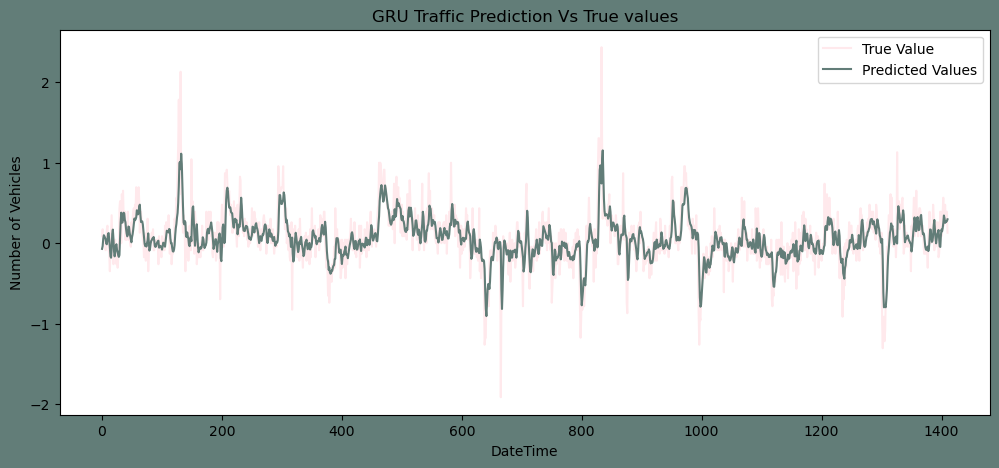

In [21]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [22]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - 155s 1s/step - loss: 0.2342
Epoch 2/50
88/88 [==============================] - 112s 1s/step - loss: 0.2052
Epoch 3/50
88/88 [==============================] - 121s 1s/step - loss: 0.1984
Epoch 4/50
88/88 [==============================] - 125s 1s/step - loss: 0.1955
Epoch 5/50
88/88 [==============================] - 126s 1s/step - loss: 0.1925
Epoch 6/50
88/88 [==============================] - 126s 1s/step - loss: 0.1936
Epoch 7/50
88/88 [==============================] - 130s 1s/step - loss: 0.1914
Epoch 8/50
88/88 [==============================] - 125s 1s/step - loss: 0.1904
Epoch 9/50
88/88 [==============================] - 117s 1s/step - loss: 0.1899
Epoch 10/50
88/88 [==============================] - 124s 1s/step - loss: 0.1908
Epoch 11/50
88/88 [==============================] - 106s 1s/step - loss: 0.1888
Epoch 12/50
88/88 [==============================] - 77s 877ms/step - loss: 0.1895
Epoch 13/50
88/88 [================

88/88 [==============================] - 84s 952ms/step - loss: 0.1840
Epoch 33/50
88/88 [==============================] - 88s 1s/step - loss: 0.1839
Epoch 34/50
88/88 [==============================] - 90s 1s/step - loss: 0.1823
Epoch 35/50
88/88 [==============================] - 89s 1s/step - loss: 0.1848
Epoch 36/50
88/88 [==============================] - 87s 992ms/step - loss: 0.1830
Epoch 37/50
88/88 [==============================] - 87s 982ms/step - loss: 0.1819
Epoch 38/50
88/88 [==============================] - 108s 1s/step - loss: 0.1825
Epoch 39/50
88/88 [==============================] - 80s 911ms/step - loss: 0.1824
Epoch 40/50
88/88 [==============================] - 168s 2s/step - loss: 0.1826
Epoch 41/50
88/88 [==============================] - 151s 2s/step - loss: 0.1814
Epoch 42/50
88/88 [==============================] - 157s 2s/step - loss: 0.1838
Epoch 43/50
88/88 [==============================] - 159s 2s/step - loss: 0.1822
Epoch 44/50
88/88 [================

The root mean squared error is 0.5520278777939454.


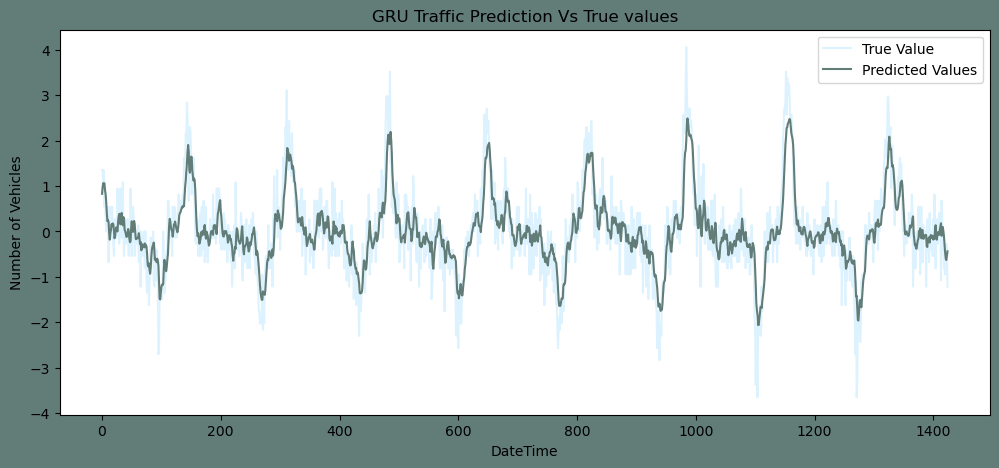

In [23]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [24]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 [==============================] - 272s 2s/step - loss: 0.3014
Epoch 2/50
88/88 [==============================] - 133s 2s/step - loss: 0.2935
Epoch 3/50
88/88 [==============================] - 78s 872ms/step - loss: 0.2913
Epoch 4/50
88/88 [==============================] - 77s 879ms/step - loss: 0.2884
Epoch 5/50
88/88 [==============================] - 76s 866ms/step - loss: 0.2883
Epoch 6/50
88/88 [==============================] - 78s 887ms/step - loss: 0.2869
Epoch 7/50
88/88 [==============================] - 75s 850ms/step - loss: 0.2904
Epoch 8/50
88/88 [==============================] - 76s 859ms/step - loss: 0.2883
Epoch 9/50
88/88 [==============================] - 76s 869ms/step - loss: 0.2927
Epoch 10/50
88/88 [==============================] - 76s 847ms/step - loss: 0.2872
Epoch 11/50
88/88 [==============================] - 75s 850ms/step - loss: 0.2889
Epoch 12/50
88/88 [==============================] - 81s 917ms/step - loss: 0.2862
Epoch 13/50
88/88

Epoch 32/50
88/88 [==============================] - 87s 995ms/step - loss: 0.2717
Epoch 33/50
88/88 [==============================] - 83s 943ms/step - loss: 0.2707
Epoch 34/50
88/88 [==============================] - 106s 1s/step - loss: 0.2694
Epoch 35/50
88/88 [==============================] - 86s 978ms/step - loss: 0.2696
Epoch 36/50
88/88 [==============================] - 83s 939ms/step - loss: 0.2713
Epoch 37/50
88/88 [==============================] - 79s 894ms/step - loss: 0.2704
Epoch 38/50
88/88 [==============================] - 79s 904ms/step - loss: 0.2712
Epoch 39/50
88/88 [==============================] - 79s 900ms/step - loss: 0.2696
Epoch 40/50
88/88 [==============================] - 72s 818ms/step - loss: 0.2687
Epoch 41/50
88/88 [==============================] - 94s 1s/step - loss: 0.2724
Epoch 42/50
88/88 [==============================] - 83s 946ms/step - loss: 0.2681
Epoch 43/50
88/88 [==============================] - 80s 905ms/step - loss: 0.2689
Epoch 44/

The root mean squared error is 0.6084281187814031.


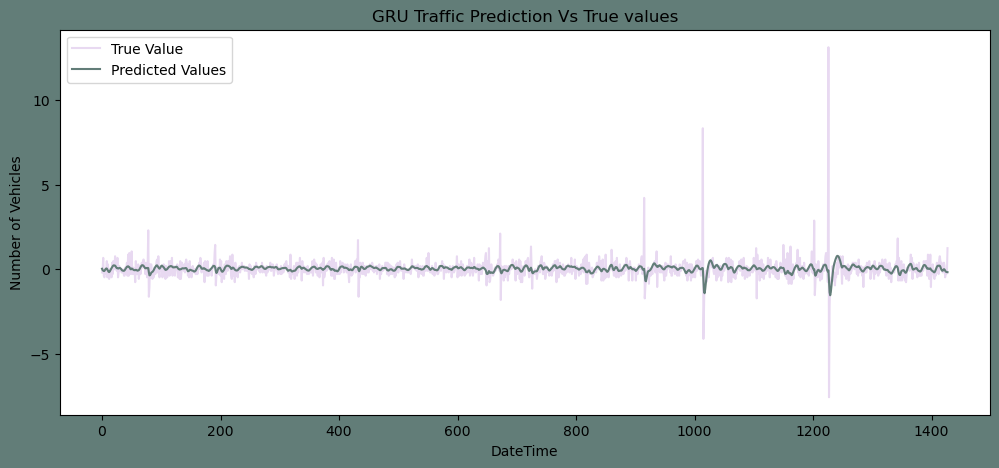

In [25]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [26]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - 78s 991ms/step - loss: 0.6894
Epoch 2/50
26/26 [==============================] - 23s 852ms/step - loss: 0.6961
Epoch 3/50
26/26 [==============================] - 22s 860ms/step - loss: 0.6889
Epoch 4/50
26/26 [==============================] - 24s 928ms/step - loss: 0.6894
Epoch 5/50
26/26 [==============================] - 22s 839ms/step - loss: 0.6868
Epoch 6/50
26/26 [==============================] - 22s 860ms/step - loss: 0.6818
Epoch 7/50
26/26 [==============================] - 24s 903ms/step - loss: 0.6801
Epoch 8/50
26/26 [==============================] - 22s 848ms/step - loss: 0.6790
Epoch 9/50
26/26 [==============================] - 22s 850ms/step - loss: 0.6804
Epoch 10/50
26/26 [==============================] - 24s 932ms/step - loss: 0.6781
Epoch 11/50
26/26 [==============================] - 23s 878ms/step - loss: 0.6830
Epoch 12/50
26/26 [==============================] - 22s 857ms/step - loss: 0.6776
Epoch 13/50
2

26/26 [==============================] - 24s 909ms/step - loss: 0.6319
Epoch 33/50
26/26 [==============================] - 49s 2s/step - loss: 0.6445
Epoch 34/50
26/26 [==============================] - 51s 2s/step - loss: 0.6218
Epoch 35/50
26/26 [==============================] - 47s 2s/step - loss: 0.6144
Epoch 36/50
26/26 [==============================] - 55s 2s/step - loss: 0.6105
Epoch 37/50
26/26 [==============================] - 48s 2s/step - loss: 0.5992
Epoch 38/50
26/26 [==============================] - 51s 2s/step - loss: 0.6049
Epoch 39/50
26/26 [==============================] - 40s 2s/step - loss: 0.5918
Epoch 40/50
26/26 [==============================] - 20s 776ms/step - loss: 0.5822
Epoch 41/50
26/26 [==============================] - 23s 875ms/step - loss: 0.5700
Epoch 42/50
26/26 [==============================] - 24s 926ms/step - loss: 0.5637
Epoch 43/50
26/26 [==============================] - 22s 856ms/step - loss: 0.5460
Epoch 44/50
26/26 [==================

The root mean squared error is 0.9921484984875666.


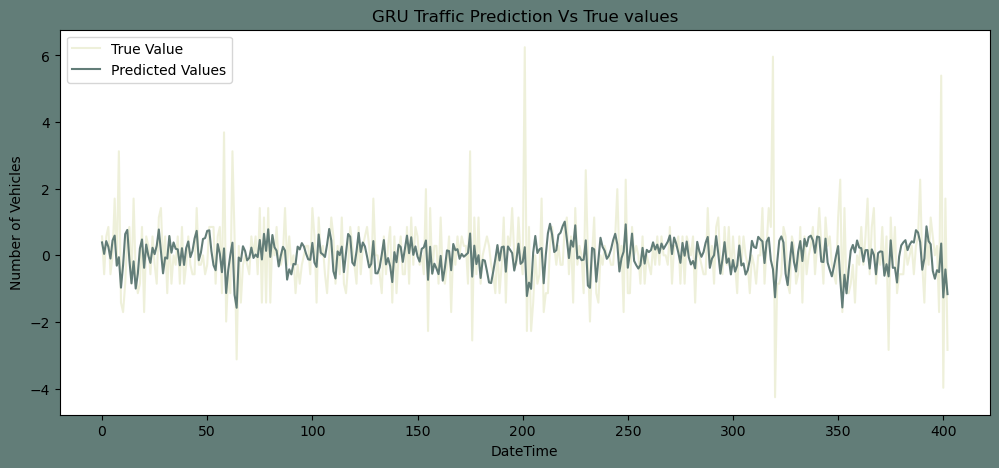

In [27]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [28]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

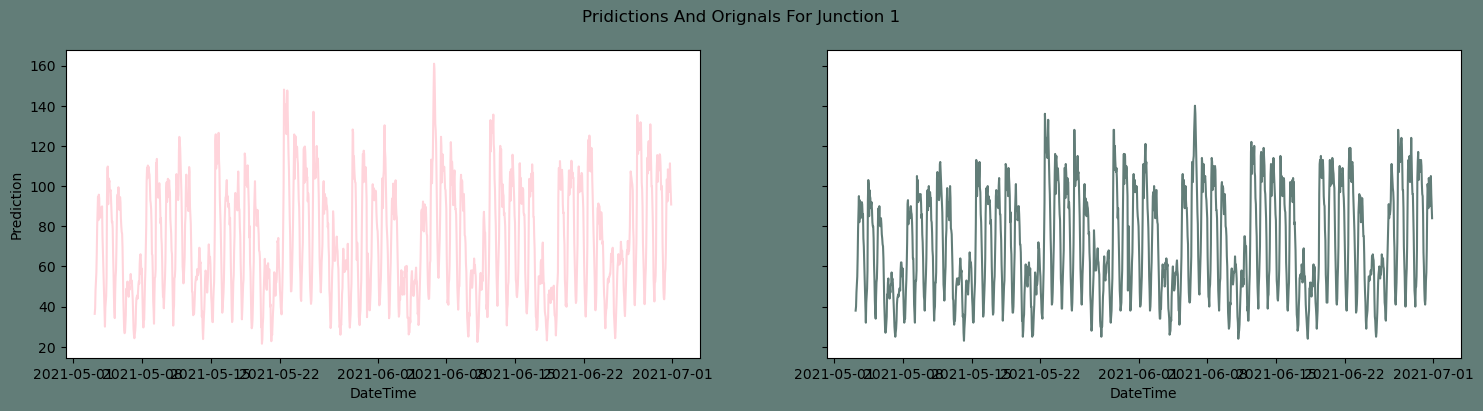

In [29]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

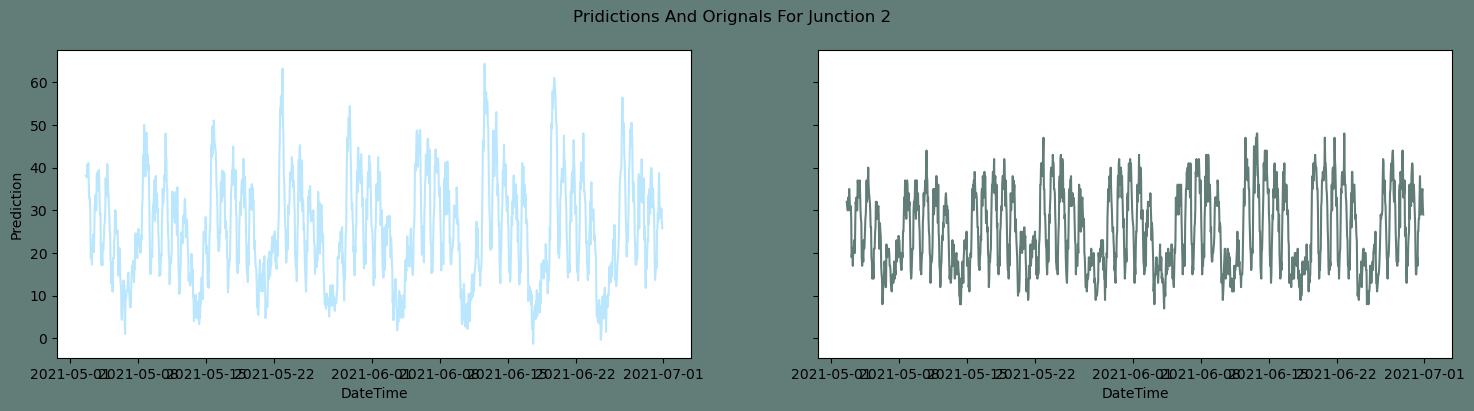

In [30]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

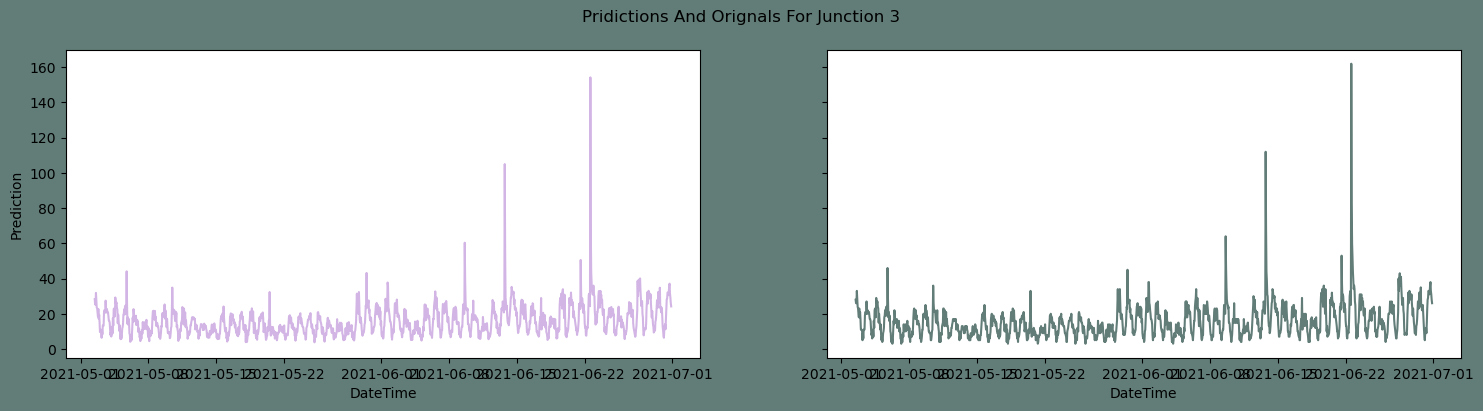

In [31]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

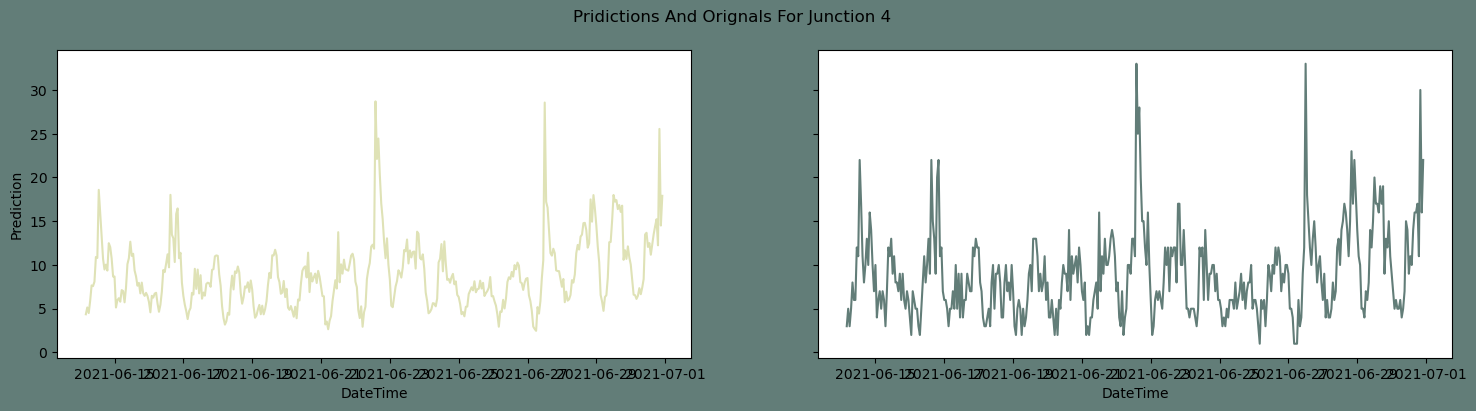

In [32]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)